In [ ]:
!pip install datasets
!pip install --force-reinstall --no-dependencies "scikit-learn==0.24.2"
!pip install sklearn-crfsuite
!pip install indic-nlp-library

In [2]:
from datasets import load_dataset
import sklearn_crfsuite
from sklearn_crfsuite import metrics 
from indicnlp.transliterate.unicode_transliterate import UnicodeIndicTransliterator
from indicnlp.langinfo import *
import warnings
warnings.filterwarnings('ignore')

In [ ]:
hi_ds = load_dataset('ai4bharat/naamapadam','hi')
te_ds = load_dataset('ai4bharat/naamapadam','te')
ml_ds = load_dataset('ai4bharat/naamapadam','ml')
sans_ds = load_dataset("wikiann", "sa")

In [5]:
def generate_sents(ds, train_size, test_size):
  train_sents = []
  test_sents = []
  for i in range(train_size):
    train_sents.append(list(zip(ds['train'][i]['tokens'],ds['train'][i]['ner_tags'])))
  for i in range(test_size):
    test_sents.append(list(zip(ds['test'][i]['tokens'],ds['test'][i]['ner_tags'])))
  return train_sents,test_sents

train_sz = 150000
test_sz = 400
#lmap = {0:'NONE', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5:'B-LOC', 6:'I-LOC'}

hi_train_sents, hi_test_sents = generate_sents(hi_ds, train_sz, test_sz)
te_train_sents, te_test_sents = generate_sents(te_ds, train_sz, test_sz)
ml_train_sents, ml_test_sents = generate_sents(ml_ds, train_sz, test_sz)

In [6]:
import string
puncs = string.punctuation

def word2features(sent, i, lang):
    word = sent[i][0]
    start_char = '.' if len(word)==0 else word[0]
    #posTag = sent[i][2]
    features = {
        'bias': 1.0,
        'word': word,
        'length': len(word),
        'sent_pos': i/len(sent),
        'is_consonant' : 1 if is_consonant(start_char, lang) else 0,
        'is_unvoiced' : 1 if is_unvoiced(start_char, lang) else 0,
        #'POS':posTag,
    }
    if i > 1:
        word1 = sent[i-1][0]
        #pos1 = sent[i-1][2]
        tag1 = sent[i-1][1]
        tag2 = sent[i-2][1]
        ispunc1 = 1 if sent[i-1][0] in puncs else 0
        features.update({
            '-1:word': word1,
            '-2:tag': tag2,
            '-1:tag': tag1,
            #'-1:POS': pos1,
            '-1:isPunc': ispunc1,
        })
    elif i > 0:
        word1 = sent[i-1][0]
        tag1 = sent[i-1][1]
        #pos1 = sent[i-1][2]
        ispunc1 = 1 if sent[i-1][0] in puncs else 0
        features.update({
            '-1:word': word1,
            '-1:tag': tag1,
            '-1:isPunc': ispunc1,
            #'-1:POS': pos1,
        })    
    else:
        features['BOS'] = True
    if i < len(sent)-2:
        word1 = sent[i+1][0]
        #pos1 = sent[i+1][2]
        tag1 = sent[i+1][1]
        tag2 = sent[i+2][1]
        ispunc1 = 1 if sent[i+1][0] in puncs else 0
        features.update({
            '+1:word': word1,
            '+1:tag': tag1,
            '+2:tag': tag2,
            '+1:isPunc': ispunc1,
            #'+1:POS': pos1,
        })
    elif i < len(sent)-1:
        word1 = sent[i+1][0]
        tag1 = sent[i+1][1]
        #pos1 = sent[i+1][2]
        ispunc1 = 1 if sent[i+1][0] in puncs else 0
        features.update({
            '+1:word': word1,
            '+1:tag': tag1,
            '+1:isPunc': ispunc1,
            #'+1:POS': pos1,
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent,lang):
    return [word2features(sent, i, lang) for i in range(len(sent))]

def sent2labels(sent):
    return [str(label) for token, label in sent]

def generate_XY_split(sents,lang):
  X = [sent2features(s,lang) for s in sents]
  y = [sent2labels(s) for s in sents]
  return X,y

In [7]:
def load_crf_model(c1,c2,max_iter):
  return sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=c1,
    c2=c2,
    max_iterations=max_iter, 
    all_possible_transitions=False,
  )

hi_crf = load_crf_model(0.1,0.1,200)
te_crf = load_crf_model(0.1,0.1,200)
ml_crf = load_crf_model(0.1,0.1,200)

In [8]:
def train_test_and_print_metrics(lang, model, train_sents, test_sents):
  X_train, y_train = generate_XY_split(train_sents, lang)
  X_test, y_test = generate_XY_split(test_sents, lang)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  labels = sorted(list(model.classes_))
  labels.remove('0')
  print("Weighted F1 of CRF = {:.4f}".format(metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels)))
  print(metrics.flat_classification_report(y_test, y_pred, labels, digits=3))
  print("\n================================================================\n")

def print_metrics(model, y_test, y_pred):
  labels = sorted(list(model.classes_))
  labels.remove('0')
  print("Weighted F1 of CRF = {:.4f}".format(metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels)))
  print(metrics.flat_classification_report(y_test, y_pred, labels, digits=3))
  print("\n================================================================\n")

In [9]:
print("Baseline performance of CRF on Hindi train and Hindi test dataset - ")
train_test_and_print_metrics('hi',hi_crf, hi_train_sents, hi_test_sents)

print("Baseline performance of CRF on Telugu train and Telugu test dataset - ")
train_test_and_print_metrics('te',te_crf, te_train_sents, te_test_sents)

print("Baseline performance of CRF on Malayalam train and Malayalam test dataset - ")
train_test_and_print_metrics('ml',ml_crf, ml_train_sents, ml_test_sents)

Baseline performance of CRF on Hindi train and Hindi test dataset - 
Weighted F1 of CRF = 0.9089
              precision    recall  f1-score   support

           1      0.927     0.874     0.900       247
           2      0.956     0.969     0.962       223
           3      0.879     0.853     0.866       231
           4      0.932     0.932     0.932       237
           5      0.946     0.839     0.889       273
           6      0.915     0.904     0.909        83

   micro avg      0.928     0.892     0.909      1294
   macro avg      0.926     0.895     0.910      1294
weighted avg      0.928     0.892     0.909      1294



Baseline performance of CRF on Telugu train and Telugu test dataset - 
Weighted F1 of CRF = 0.8231
              precision    recall  f1-score   support

           1      0.890     0.789     0.836       298
           2      0.891     0.920     0.905       275
           3      0.764     0.651     0.703       129
           4      0.805     0.874     0.83

In [10]:
sans_test_sents = []
subset = ['train','test','validation']
for split in subset:
  for i in range(len(sans_ds[split])):
    sans_test_sents.append(list(zip(sans_ds[split][i]['tokens'],sans_ds[split][i]['ner_tags'])))

sans_bl_train_sents = sans_test_sents[:200]
sans_bl_test_sents = sans_test_sents[200:]

print(len(sans_test_sents),len(sans_bl_train_sents),len(sans_bl_test_sents))

300 200 100


In [11]:
#sanskrit baseline
sans_crf = load_crf_model(0.1,0.01,10)
print("Sanskrit Baseline CRF on 200 Sanskrit train samples and 100 Sanskrit test samples - ")
train_test_and_print_metrics('hi',sans_crf, sans_bl_train_sents, sans_bl_test_sents)

Sanskrit Baseline CRF on 200 Sanskrit train samples and 100 Sanskrit test samples - 
Weighted F1 of CRF = 0.1761
              precision    recall  f1-score   support

           1      0.000     0.000     0.000        36
           2      0.000     0.000     0.000        63
           3      0.000     0.000     0.000        36
           4      0.772     0.759     0.765        58
           5      0.000     0.000     0.000        46
           6      0.000     0.000     0.000        13

   micro avg      0.537     0.175     0.263       252
   macro avg      0.129     0.126     0.128       252
weighted avg      0.178     0.175     0.176       252





In [12]:
sans_X_test, sans_y_test = generate_XY_split(sans_test_sents,'hi')

print("Performance of Hindi-CRF on Sanskrit script test samples - ")
print_metrics(hi_crf, sans_y_test, hi_crf.predict(sans_X_test))

print("Performance of Telugu-CRF on Sanskrit script test samples - ")
print_metrics(te_crf, sans_y_test, te_crf.predict(sans_X_test))

print("Performance of Malayalam-CRF on Sanskrit script test samples - ")
print_metrics(ml_crf, sans_y_test, ml_crf.predict(sans_X_test))

Performance of Hindi-CRF on Sanskrit script test samples - 
Weighted F1 of CRF = 0.3361
              precision    recall  f1-score   support

           1      0.196     0.200     0.198       110
           2      0.513     0.706     0.594       163
           3      0.211     0.215     0.213       107
           4      0.457     0.369     0.408       160
           5      0.269     0.092     0.137       152
           6      0.882     0.283     0.429        53

   micro avg      0.386     0.333     0.357       745
   macro avg      0.422     0.311     0.330       745
weighted avg      0.388     0.333     0.336       745



Performance of Telugu-CRF on Sanskrit script test samples - 
Weighted F1 of CRF = 0.1807
              precision    recall  f1-score   support

           1      0.071     0.027     0.039       110
           2      0.083     0.018     0.030       163
           3      0.352     0.299     0.323       107
           4      0.533     0.606     0.567       160
       

In [13]:
def generate_transliterated_sans_sents(src_ds, src_lang, dest_lang):
  trans_sents = []
  subset = ['train','test','validation']
  for split in subset:
    for i in range(len(src_ds[split])):
      trans_tok = []
      for tok in src_ds[split][i]['tokens']:
        trans_tok.append(UnicodeIndicTransliterator.transliterate(tok,src_lang,dest_lang))
      trans_sents.append(list(zip(trans_tok,sans_ds[split][i]['ner_tags'])))  

  return trans_sents

sans_trans_hi_sents = generate_transliterated_sans_sents(sans_ds,"sa","hi")
sans_trans_te_sents = generate_transliterated_sans_sents(sans_ds,"sa","te")
sans_trans_ml_sents = generate_transliterated_sans_sents(sans_ds,"sa","ml")

print(sans_test_sents[10])
print(sans_trans_hi_sents[10])
print(sans_trans_te_sents[10])
print(sans_trans_ml_sents[10])

[('पुनर्निदेशन', 0), ('एस्', 1), ('एल्', 2), ('भैरप्प', 2)]
[('पुनर्निदेशन', 0), ('एस्', 1), ('एल्', 2), ('भैरप्प', 2)]
[('పునర్నిదేశన', 0), ('ఏస్', 1), ('ఏల్', 2), ('భైరప్ప', 2)]
[('പുനര്നിദേശന', 0), ('ഏസ്', 1), ('ഏല്', 2), ('ഭൈരപ്പ', 2)]


In [14]:
sans_hi_X_test, sans_hi_y_test = generate_XY_split(sans_trans_hi_sents,'hi')
sans_te_X_test, sans_te_y_test = generate_XY_split(sans_trans_te_sents,'te')
sans_ml_X_test, sans_ml_y_test = generate_XY_split(sans_trans_ml_sents,'ml')

In [15]:
print("Performance of Hindi-CRF on Sanskrit test samples transliterated to Hindi - ")
print_metrics(hi_crf, sans_hi_y_test, hi_crf.predict(sans_hi_X_test))

print("Performance of Telugu-CRF on Sanskrit test samples transliterated to Telugu - ")
print_metrics(te_crf, sans_te_y_test, te_crf.predict(sans_te_X_test))

print("Performance of Malayalam-CRF on Sanskrit test samples transliterated to Malayalam - ")
print_metrics(hi_crf, sans_ml_y_test, ml_crf.predict(sans_ml_X_test))

Performance of Hindi-CRF on Sanskrit test samples transliterated to Hindi - 
Weighted F1 of CRF = 0.3361
              precision    recall  f1-score   support

           1      0.196     0.200     0.198       110
           2      0.513     0.706     0.594       163
           3      0.211     0.215     0.213       107
           4      0.457     0.369     0.408       160
           5      0.269     0.092     0.137       152
           6      0.882     0.283     0.429        53

   micro avg      0.386     0.333     0.357       745
   macro avg      0.422     0.311     0.330       745
weighted avg      0.388     0.333     0.336       745



Performance of Telugu-CRF on Sanskrit test samples transliterated to Telugu - 
Weighted F1 of CRF = 0.3016
              precision    recall  f1-score   support

           1      0.324     0.200     0.247       110
           2      0.563     0.301     0.392       163
           3      0.368     0.299     0.330       107
           4      0.541   

#Result comparison for different feature sets </br>
without linguistic features, transliteration is pointless.</br>
possible metric - compare with and w/o linguistic feeture performance.</br>
https://www.analyticsvidhya.com/blog/2020/01/3-important-nlp-libraries-indian-languages-python/</br>

Feature set1 <br>
Experiment with 5-gram NER tags only<br>
train_sz - 100000, test_sz - 400

|src-dest_tr | hi-hi | te-te | ma-ma | sa-sa | hi-sa | te-sa | ma-sa | hi-sa_hi | te-sa_te | ma-sa_ma |
|------------|-------|-------|-------|-------|-------|-------|-------|----------|----------|----------|  
|weighted F1 |0.8766 |0.7989 |0.7599 |0.1641 |0.2207 |0.1236 |0.0932 | 0.2207   | 0.2189   | 0.1580   |

<br>
Feature set2 <br>
Experiment after adding following - 
- length of word
- position in sentence as a [0,1] real value

|src-dest_tr | hi-hi | te-te | ma-ma | sa-sa | hi-sa | te-sa | ma-sa | hi-sa_hi | te-sa_te | ma-sa_ma |
|------------|-------|-------|-------|-------|-------|-------|-------|----------|----------|----------|  
|weighted F1 |0.8764 |0.8204 |0.7796 |0.1986 |0.2680 |0.2670 |0.2091 |   0.2680 |   0.3229 | 0.1973   |

<br>
Feature set3 <br>
Experiment after adding following - 
- is_punctuation +1/-1

train_sz - 100000, test_sz - 400

|src-dest_tr | hi-hi | te-te | ma-ma | sa-sa | hi-sa | te-sa | ma-sa | hi-sa_hi | te-sa_te | ma-sa_ma |
|------------|-------|-------|-------|-------|-------|-------|-------|----------|----------|----------|  
|weighted F1 |0.8870 |0.8195 |0.8195 |0.1938 |0.3268 |0.2505 |0.2310 |   0.3268 |   0.3664 | 0.2307   |

#### - ignore ------
train_sz - 200000, test_sz - 400

|src-dest_tr | hi-hi | te-te | ma-ma | sa-sa | hi-sa | te-sa | ma-sa | hi-sa_hi | te-sa_te | ma-sa_ma |
|------------|-------|-------|-------|-------|-------|-------|-------|----------|----------|----------|  
|weighted F1 |0.9089 |0.8281 |0.8162 |0.1938 |0.3531 |0.2530 |0.3012 | 0.3531   | 0.3419   | 0.2827   |

#### - ignore ------

Feature set4 <br>
Experiment after adding following on first character - 
- is_consonant
- is_unvoiced

train_sz - 100000, test_sz - 400

|src-dest_tr | hi-hi | te-te | ma-ma | sa-sa | hi-sa | te-sa | ma-sa | hi-sa_hi | te-sa_te | ma-sa_ma |
|------------|-------|-------|-------|-------|-------|-------|-------|----------|----------|----------|  
|weighted F1 |0.9089 |0.8231 |0.8395 |0.1761 |0.3361 |0.1807 |0.2057 | 0.3361   | 0.3061   | 0.2900   |

# features to consider - 
- POS tags +-1 / +-2 (stanford NLP suite)


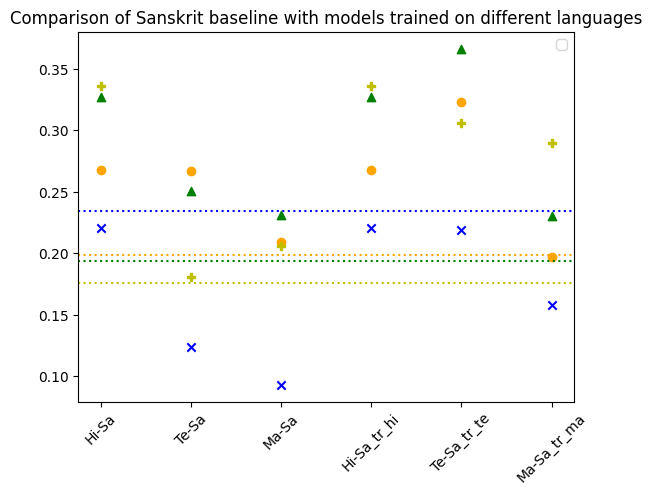

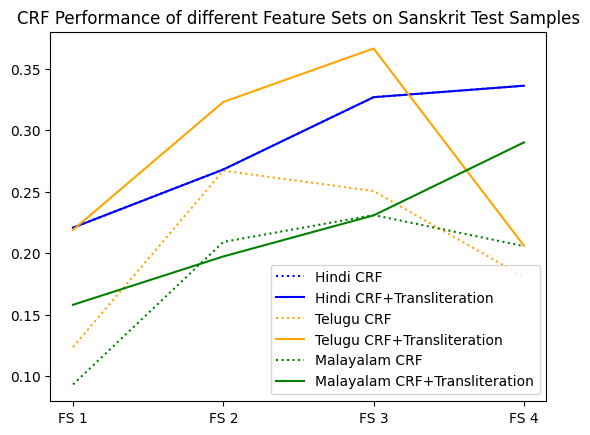

In [25]:
#plots
import matplotlib.pyplot as plt
x = ['sa Baseline', 'Hi-Sa','Te-Sa', 'Ma-Sa','Hi-Sa_tr_hi','Te-Sa_tr_te', 'Ma-Sa_tr_ma']
e = [[0.2344, 0.2207,	0.1236,	0.0932, 0.2207, 0.2189, 0.1580],[0.1986,	0.2680,	0.2670,	0.2091,	0.2680,	0.3229,	0.1973],[0.1938,0.3268,0.2505,0.2310,0.3268,0.3664,0.2307], [0.1761,0.3361,0.1807,0.2057,0.3361,0.3061,0.2900]]

c = ['b','orange','g','y']
m = ['x','o','^','P']
lab = ['Sanskrit Baseline', 'Hindi CRF','Hindi CRF+Transliteration', 'Telugu CRF','Telugu CRF+Transliteration', 'Malayalam CRF', 'Malayalam CRF+Transliteration']
for i in range(4):
  plt.axhline(y = e[i][0], linestyle = 'dotted', color = c[i])
  plt.scatter(x[1:],e[i][1:],c = c[i],marker=m[i])
  plt.xticks(rotation=45)
  plt.legend()
plt.title('Comparison of Sanskrit baseline with models trained on different languages')
plt.show()

x2 = ['FS 1', 'FS 2', 'FS 3', 'FS 4']
e2 = [[0.2344,0.1986,0.1938,0.1761],[0.2207,0.2680, 0.3268,0.3361],[0.2207,0.2680, 0.3268,0.3361],[0.1236, 0.2670,0.2505,0.1807], [0.2189, 0.3229,0.3664,0.2061], [0.0932,0.2091, 0.2310, 0.2057],[0.1580, 0.1973, 0.2307, 0.2900]]

for i in range(1,7,2):
  plt.plot(x2,e2[i],label=lab[i],linestyle='dotted',c=c[i//2])
  plt.plot(x2,e2[i+1],label=lab[i+1],c=c[i//2])
  plt.legend()
plt.title('CRF Performance of different Feature Sets on Sanskrit Test Samples')
plt.show()